<a href="https://colab.research.google.com/github/SashelI/IMED_Project_BRATS_Segm/blob/main/IMED_PROJET_BORDIN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sources :


*   https://arxiv.org/abs/1505.04597v1
*   https://github.com/LightersWang/3DUNet-BraTS-PyTorch
*   https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
*   https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch
*   https://github.com/karolzak/keras-unet



---



#Imports

---



In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shutil
import sklearn
import tensorflow as tf
import keras

from __future__ import print_function
from PIL import Image
from sklearn.cluster import KMeans
from IPython.display import HTML
from torch.utils.data import Dataset, DataLoader
from os.path import join
from sklearn.ensemble import RandomForestClassifier
from skimage import data, segmentation, feature, future
from functools import partial
from sklearn.ensemble import RandomForestClassifier


!pip install nibabel pydicom medpy
from medpy.io import load
from medpy.io import save

!pip install keras-unet
from keras_unet.models import custom_unet
from keras_unet.utils import plot_imgs
from keras import backend as K

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.5 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214964 sha256=0960af0fca24abbf93a23e8062cdc8252bbc90cb232bcda1e857420de9c8043e
  Stored in directory: /root/.cache/pip/wheels/fc/38/7d/e0b8bcb2770f779a93cab5ab7fa6dd344011e1278cb90cab86
Successfully built medpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


#Inputs and Data

---



##Inputs

In [ ]:
# Root directory for dataset
data_dir = "/content/drive/MyDrive/IMED2/Projet/data/"

# Batch size during training
batch_size = 16

# Number of training epochs
num_epochs = 50

#Layer to watch
train_layer = 105
test_layer = 100

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


##Data

Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HGG_train_dir = os.path.join(data_dir, "BRATS2015_Training/HGG")
LGG_train_dir = os.path.join(data_dir, "BRATS2015_Training/LGG")
test_dir = os.path.join(data_dir, "BRATS2015_Testing/HGG_LGG")

hgg_train_fns = os.listdir(HGG_train_dir)
lgg_train_fns = os.listdir(LGG_train_dir)
test_fns = os.listdir(test_dir)

### Mise en forme du dataset
(à ne lancer qu'une seule fois)

In [ ]:
#for f in os.listdir(niipath):
#os.remove(os.path.join(niipath, f))

### USED TO GET ALL DATA ###
# for e in test_fns:
#   subdir = os.path.join(test_dir, e)
#   sub_name = e.replace("/", "")
#   niipath = os.path.join(subdir, 'NII/')
#   if not os.path.exists(niipath):
#       os.mkdir(niipath)
#   print(niipath)
#   for folder in os.listdir(subdir):
#       sub_subdir = os.path.join(subdir, folder)
#       for f in os.listdir(sub_subdir):
#         if f.endswith('.mha'):
#            image_data, image_header = load(os.path.join(sub_subdir, f))
#            if 'Flair' in f:
#              save(image_data, niipath + sub_name + '_flair.nii')
#            elif 'T1c' in f:
#              save(image_data, niipath + sub_name + '_t1ce.nii')
#            elif 'T1' in f:
#              save(image_data, niipath + sub_name + '_t1.nii')
#            elif 'T2' in f:
#              save(image_data, niipath + sub_name + '_t2.nii')
#            else :
#              save(image_data, niipath + sub_name + '_seg.nii')

### Initialisation et pré-traitement du Dataset

In [ ]:
class BratsDataset(Dataset):
    def __init__(self, data_root:str, case_names:list=[], mode:str="none", transform=None):
        super(BratsDataset, self).__init__()

        self.data_root = data_root
        self.case_names = case_names
        self.transform = transform
        self.mode = mode

    def __getitem__(self, index:int) -> tuple:
        name = self.case_names[index]
        base_dir = join(self.data_root, name, 'NII/' + name)

        layer=73
        if self.mode == "train":
          layer = train_layer
        else:
          layer = test_layer

        flair = np.array(load(base_dir + '_flair.nii')[0][:,:,layer], dtype='float32')
        t1    = np.array(load(base_dir + '_t1.nii')[0][:,:,layer], dtype='float32')
        t1ce  = np.array(load(base_dir + '_t1ce.nii')[0][:,:,layer], dtype='float32')
        t2    = np.array(load(base_dir + '_t2.nii')[0][:,:,layer], dtype='float32')
        if self.mode=="train" :
          mask  = np.array(load(base_dir + '_seg.nii')[0][:,:,layer], dtype='float32')  # ground truth
        else:
          mask = np.zeros(t2.size, dtype='uint8')

        data = np.stack([flair, t1, t1ce, t2], axis=2)

        return data, mask

    def __len__(self):
        return len(self.case_names)

In [ ]:
train_dataset = BratsDataset(data_root = HGG_train_dir,
                             case_names = hgg_train_fns,
                             mode="train",
                             )

test_dataset = BratsDataset(data_root = test_dir,
                            case_names = test_fns,
                            mode="test",
                             )

Display some Data

Number of images in the train set 385.
Number of images in the test set 40.


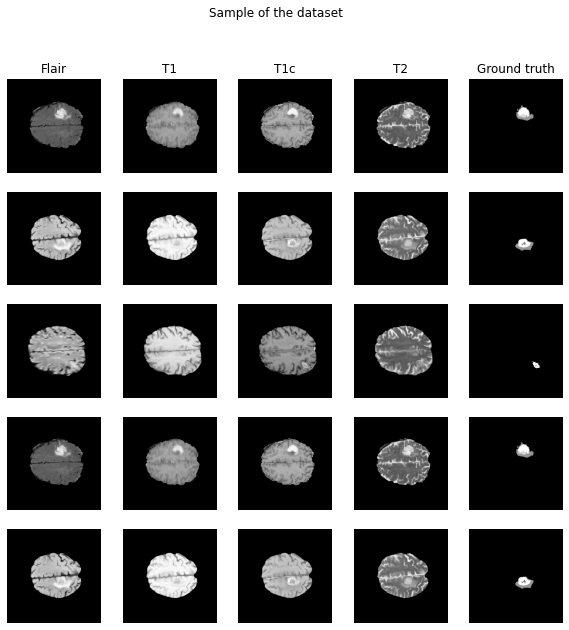

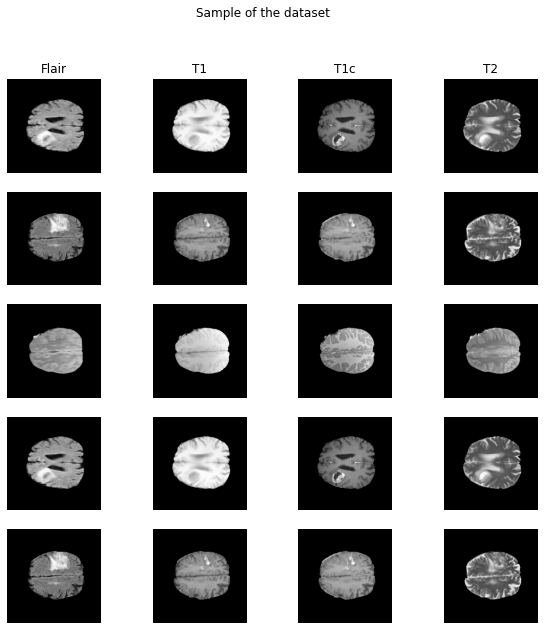

In [ ]:
img,test = train_dataset[3]
print(f"Number of images in the train set {len(hgg_train_fns) * 5 + len(lgg_train_fns) * 5}.")
print(f"Number of images in the test set {len(test_fns) * 5}.")

fig, ax = plt.subplots(5, 5, figsize=(10,10))

ax[0][0].set_title('Flair')
ax[0][1].set_title('T1')
ax[0][2].set_title('T1c')
ax[0][3].set_title('T2')
ax[0][4].set_title('Ground truth')

for i in range(5):
    img,label = train_dataset[(i % 3) * 3]
    for j in range(4):

        current_ax = ax[i][j]
        current_ax.imshow(img[:,:,j], cmap='Greys_r')
        current_ax.axis('off')
    current_ax = ax[i][4]
    current_ax.imshow(label, cmap='Greys_r')
    current_ax.axis('off')

fig.suptitle('Sample of the train dataset')
fig.show()

fig2, ax = plt.subplots(5, 4, figsize=(10,10))

ax[0][0].set_title('Flair')
ax[0][1].set_title('T1')
ax[0][2].set_title('T1c')
ax[0][3].set_title('T2')

for i in range(5):
    img,label = test_dataset[(i % 3) * 3]
    for j in range(4):

        current_ax = ax[i][j]
        current_ax.imshow(img[:,:,j], cmap='Greys_r')
        current_ax.axis('off')

fig2.suptitle('Sample of the test dataset')
fig2.show()

#Modèles

---



## Unet (Keras)

Définition de la Dice Loss

In [ ]:
## Loss
def DiceLoss(y_true, y_pred, smooth=10):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)
    return 1 - dice

Création du modèle

In [ ]:
model = custom_unet(
    input_shape=(240, 240, 1),
    use_batch_norm=True,
    num_classes=5,
    filters=64,
    dropout=0.2,
    output_activation=None)

Mise en forme du dataset pour le modèle

In [ ]:
imgs = []
labels = []

for i in range(0,16):
  img, label = train_dataset[i]
  label0 = np.where((label==0.0),1.0,0.0)
  label1 = np.where((label==1.0),1.0,0.0)
  label2 = np.where((label==2.0),1.0,0.0)
  label3 = np.where((label==3.0),1.0,0.0)
  label4 = np.where((label==4.0),1.0,0.0)
  label_stack = np.stack([label0, label1, label2, label3, label4], axis=2)
  for j in range(0,4):
    imgs.append(img[:,:,j])
    labels.append(label_stack)
imgs=np.array(imgs)
labels=np.array(labels)
print(imgs.shape, labels.shape)

(64, 240, 240) (64, 240, 240, 5)


### Entraînement

In [ ]:
model.compile(optimizer='Adam', loss=DiceLoss)
model.fit(x=imgs, y=labels, batch_size=batch_size, epochs=num_epochs)

Epoch 1/50
4/4 [==============================] - 34s 952ms/step - loss: 0.9767
Epoch 2/50
4/4 [==============================] - 4s 955ms/step - loss: 0.9462
Epoch 3/50
4/4 [==============================] - 4s 956ms/step - loss: 0.8820
Epoch 4/50
4/4 [==============================] - 4s 953ms/step - loss: 0.7894
Epoch 5/50
4/4 [==============================] - 4s 954ms/step - loss: 0.6898
Epoch 6/50
4/4 [==============================] - 4s 956ms/step - loss: 0.5959
Epoch 7/50
4/4 [==============================] - 4s 947ms/step - loss: 0.5038
Epoch 8/50
4/4 [==============================] - 4s 942ms/step - loss: 0.4190
Epoch 9/50
4/4 [==============================] - 4s 937ms/step - loss: 0.3381
Epoch 10/50
4/4 [==============================] - 4s 940ms/step - loss: 0.2702
Epoch 11/50
4/4 [==============================] - 4s 933ms/step - loss: 0.2102
Epoch 12/50
4/4 [==============================] - 4s 933ms/step - loss: 0.1597
Epoch 13/50
4/4 [==============================]

Prédictions sur 5 coupes de test

In [ ]:
full_test, labeltest = test_dataset[4]

test_img1 = full_test[:,:,0]
test_img2 = full_test[:,:,1]
test_img3 = full_test[:,:,2]
test_img4 = full_test[:,:,3]

imgtest1 = test_img1[np.newaxis, :,:]
imgtest2 = test_img2[np.newaxis, :,:]
imgtest3 = test_img3[np.newaxis, :,:]
imgtest4 = test_img4[np.newaxis, :,:]

pred1 = model.predict(imgtest1)
pred2 = model.predict(imgtest2)
pred3 = model.predict(imgtest3)
pred4 = model.predict(imgtest4)

np.clip(pred1, 0, 1, pred1)
np.clip(pred2, 0, 1, pred2)
np.clip(pred3, 0, 1, pred3)
np.clip(pred4, 0, 1, pred4)

full_pred1 = np.zeros((240,240))
full_pred2 = np.zeros((240,240))
full_pred3 = np.zeros((240,240))
full_pred4 = np.zeros((240,240))
for k in range(0,5):
  for i in range(0,240):
    for j in range(0,240):
      if pred1[0,i,j,k]>0.5:
        full_pred1[i,j]=k
      if pred2[0,i,j,k]>0.5:
        full_pred2[i,j]=k
      if pred3[0,i,j,k]>0.5:
        full_pred3[i,j]=k
      if pred4[0,i,j,k]>0.5:
        full_pred4[i,j]=k

1/1 [==============================] - 0s 24ms/step


Affichage

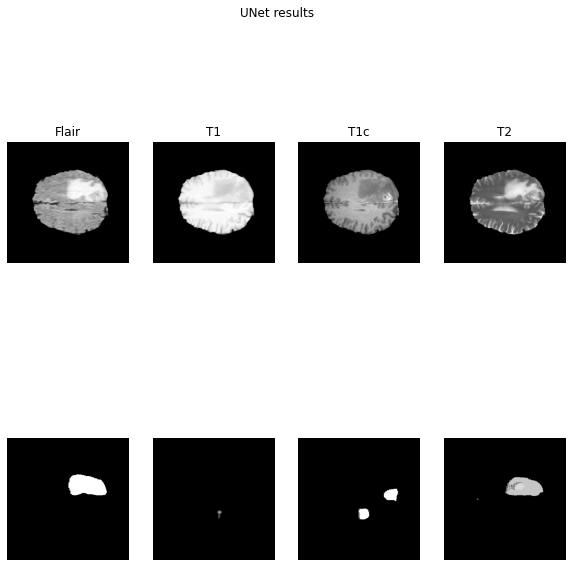

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10,10))

ax[0][0].set_title('Flair')
ax[0][1].set_title('T1')
ax[0][2].set_title('T1c')
ax[0][3].set_title('T2')

ax[0][0].imshow(test_img1, cmap='Greys_r')
ax[0][0].axis('off')

ax[0][1].imshow(test_img2, cmap='Greys_r')
ax[0][1].axis('off')

ax[0][2].imshow(test_img3, cmap='Greys_r')
ax[0][2].axis('off')

ax[0][3].imshow(test_img4, cmap='Greys_r')
ax[0][3].axis('off')

ax[1][0].imshow(full_pred1, cmap='Greys_r')
ax[1][0].axis('off')

ax[1][1].imshow(full_pred2, cmap='Greys_r')
ax[1][1].axis('off')

ax[1][2].imshow(full_pred3, cmap='Greys_r')
ax[1][2].axis('off')

ax[1][3].imshow(full_pred4, cmap='Greys_r')
ax[1][3].axis('off')

# ax[2][0].imshow(labeltest, cmap='Greys_r')
# ax[2][0].axis('off')
# ax[2][1].axis('off')
# ax[2][2].axis('off')
# ax[2][3].axis('off')

fig.suptitle('UNet results')
fig.show()

## random forest en mode segmentation

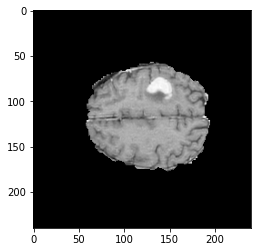

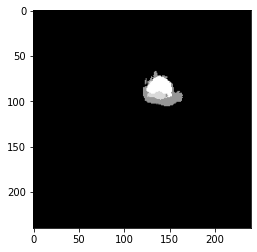

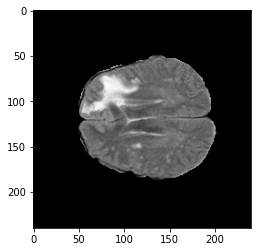

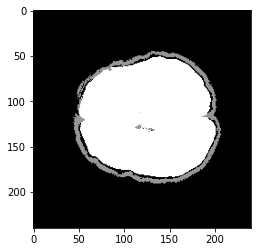

In [ ]:
imgtest, labeltest = test_dataset[22]
imgtest=imgtest[:,:,0]
img, label = train_dataset[0]
img = img[:,:,2]

sigma_min = 0.5
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max)

model = RandomForestClassifier(n_estimators=100, max_depth=100)

# for i in range(0,10):
#   img, label = train_dataset[i]
#   img = img[:,:,0]
features = features_func(img)
model = future.fit_segmenter(label, features, model)

test_features = features_func(imgtest)
pred = future.predict_segmenter(test_features, model)

plt.imshow(img, cmap='Greys_r')
plt.show()
plt.imshow(label, cmap='Greys_r')
plt.show()

plt.imshow(imgtest, cmap='Greys_r')
plt.show()
plt.imshow(pred, cmap='Greys_r')
plt.show()

## random forest simple

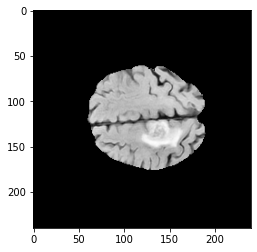

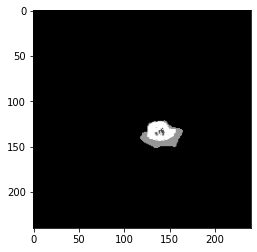

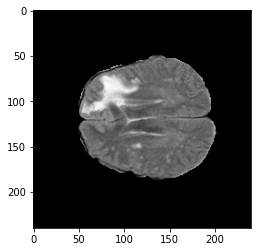

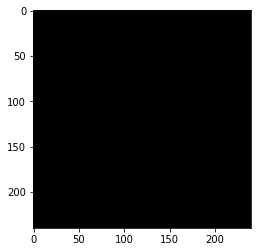

In [ ]:
imgtest, labeltest = test_dataset[0]
imgtest=imgtest[:,:,0]
model_simple = RandomForestClassifier(max_depth=5)

img, label = train_dataset[3]
img = img[:,:,0]
model_simple.fit(img, label)

# for i in range(0,5):
#   img, label = train_dataset[i]
#   model_simple.fit(img[:,:,0], label)
#   print(i)

pred = model_simple.predict(imgtest)

plt.imshow(img, cmap='Greys_r')
plt.show()
plt.imshow(label, cmap='Greys_r')
plt.show()

plt.imshow(imgtest, cmap='Greys_r')
plt.show()
plt.imshow(pred, cmap='Greys_r')
plt.show()